In dieser Übung wird ein Kreis an eine verrauschte Punktewolke angepasst. 
Dabei wird im ersten Teil die analytische Lösung zum Berrechnen des Kreismittelpunkts $(m_x,m_y)^T \in \mathbb{R}^2$ bei gegebenem Radius $r \in \mathbb{R}^+$ ermittelt.
Im zweiten Teil wird eine numerische Lösung für $m_x,m_y$ und $r$ gesucht. Dabei wird im ersten Schritt eine Schätzung analytisch bestimmt.
Diese initiale Lösung wird anschließend mit Hilfe eines Gradientenabstiegsverfahrens optimiert.

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

Schreiben Sie eine Funktion $\mathit{circlePoint}$ mit

$
M_x, M_y, R, \theta \mapsto 
\begin{pmatrix}
R\cos(\theta) + M_x + \rho_x\\
R\sin(\theta) + M_y + \rho_y
\end{pmatrix}, 
\quad \rho_x,\rho_y \sim N(0,\frac{1}{100}) 
$

Schreiben Sie eine weitere Funktion $\mathit{sampleCirclePointsNoisy}$ welche statt $\theta$ einen Vektor $\Theta \in \mathbb{R}^{1000}$ auf eine Matrix in $\mathbb{R}^{2 \times 1000}$ abbildet. An diese erzeugten Daten wird anschließend ein Kreis angepasst

In [3]:
def circlePoint(m,r,theta):
    x = np.cos(theta).reshape(1,-1)
    y = np.sin(theta).reshape(1,-1)
    pts = np.vstack([x,y])
    return (r*pts+m)
def sampleCirclePointsNoisy(m,r,theta):
    pts = circlePoint(m,r,theta)
    noise = np.random.normal(scale=.01,size=theta.shape[0])
    return (pts+noise)

Ziehen sie $1000$ Zahlen gleichverteilt aus $\Theta \sim [0,\frac{\pi}{2}]^{1000}$ und berechnen Sie $\mathit{sampleCirclePointsNoisy}(0,0,2,\Theta)$.

In [4]:
MX, MY, R = 0.0,0.0,2.0
thetas = np.random.uniform(high=.5*np.pi,size=1000)
data = sampleCirclePointsNoisy(np.array([[MX],[MY]]),R,thetas)

Plotten Sie die Punktewolke mit matplotlib

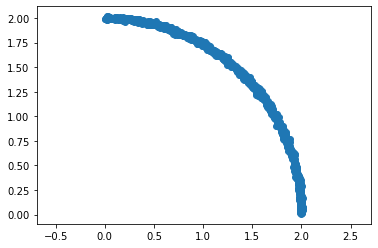

In [5]:
plt.axis('equal')
plt.scatter(data[0],data[1])

Implementieren Sie die Funktion $\mathit{fitCenteredCircle}$ aus den Vorlesungsfolien zur analytischen Bestimmung des Radius $r$ aus der Punktewolke

In [6]:
def fitCenteredCircle(y):
    r = np.linalg.norm(y,axis=0).mean()
    return 0,0,r

In [7]:
mx,my,r = fitCenteredCircle(data)

In [8]:
def draw(mx,my,r, data):
    circle1=plt.Circle((mx,my),r,color='r',fill=False)
    axes = plt.gca()
    axes.set_xlim([-3,3])
    axes.set_ylim([-3,3])
    plt.gca().set_aspect('equal', adjustable='box')
    axes.add_artist(circle1)
    plt.scatter(data[0],data[1])
    plt.show()

Plotten Sie Ihre Lösung mit Hilfe der $\mathit{draw}$ Funktion

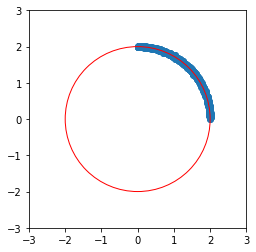

In [9]:
draw(mx,my,r,data)

Implementieren Sie eine Funktion $f$, welche die Kosten für Ihren Fit berechnet für beliebige Kreisparameter $m_x,m_y,r$ und Punktewolke $d$ bestimmt.

$f(m_x,m_y,r,d) = \sum_{i=1}^{1000} \left(\sqrt{(m_x - d_{0,i})^2 + (m_y - d_{1,i})^2} - r\right)^2$

In [10]:
def residual(mx,my,r,d):
    c = np.array([[mx],[my]])
    res = np.linalg.norm(c-d,axis=0) - r
    return res
def f(mx,my,r,d):
    resiudal = residual(mx,my,r,d)
    error = (resiudal**2).sum()
    return error

Emitteln Sie die Kosten für Ihre Lösung mit Hilfe von $f$.

In [11]:
r = .5
f(mx,my,r,data)

2249.1936007302465

Plotten Sie $f(0,0,r,d)$ für $r \in [0,5]$. Was fällt Ihnen auf?

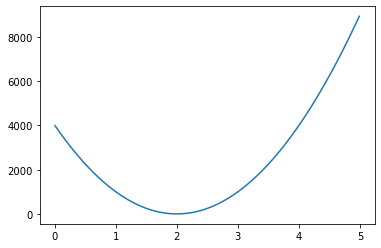

In [12]:
xsample = .01*np.arange(500)
ysample = np.zeros(500)
for i in range(0,500):
    ysample[i] = f(mx,my,xsample[i],data)
plt.plot(xsample,ysample)

Plotten Sie $f(x,y,2,d)$ für $(x,y) \in [-3,5] \times [0,3]$. Was fällt Ihnen auf?

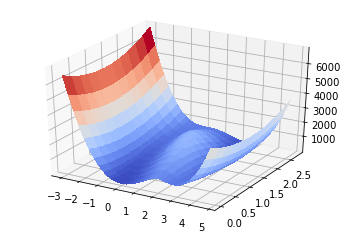

In [13]:
X = np.arange(-3, 5, 0.25)
Y = np.arange(0, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = []
for x,y in zip(X.ravel(),Y.ravel()):
    Z += [f(x,y,2,data)]
Z = np.array(Z).reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

Implementieren sie eine Funktion $\mathit{grad}$ mit den selben Parametern wir $f$, welche den Gradienten an einer gegebenen Position berechnet

$\nabla f = (\frac{\partial f}{\partial m_x},\frac{\partial f}{\partial m_y},\frac{\partial f}{\partial r})^T$

In [14]:
def grad(mx,my,r,d):
    m = np.array([mx,my])
    res = residual(mx,my,r,d)
    d_center = np.reciprocal(np.linalg.norm(m-d.T,axis=1))
    denom_dmx = mx-d[0]
    df_dmx_inner = d_center*denom_dmx
    denom_dmy = my-d[1]
    df_dmy_inner = d_center*denom_dmy
    
    df_dmx = (2*res*df_dmx_inner).sum()
    df_dmy = (2*res*df_dmy_inner).sum()

    df_dr = (2*res*(-1)).sum()
    
    return df_dmx,df_dmy,df_dr

Schreiben sie eine Funktion $\mathit{grad\_finite}$, welche $\nabla f$ mit Hilfe des zentralen Differenzenquotienten bestimmt:

$\nabla_h f = \left(\frac{f(m_x+h,m_y,r,d) - f(m_x-h,m_y,r,d)}{2h},\frac{f(m_x,m_y+h,r,d) - f(m_x,m_y-h,r,d)}{2h},\frac{f(m_x,m_y,r+h,d) - f(m_x,m_y,r-h,d)}{2h} \right)^T$

In [15]:
def grad_finite(mx,my,r,d):
    h = 1E-5
    df_dmx_n = (f(mx+h,my,r,d) - f(mx-h,my,r,d))/(2*h)
    df_dmy_n = (f(mx,my+h,r,d) - f(mx,my-h,r,d))/(2*h)
    df_dr_n = (f(mx,my,r+h,d) - f(mx,my,r-h,d))/(2*h)
    dn = np.array([df_dmx_n,df_dmy_n,df_dr_n])
    return dn

Schreiben Sie eine Funktion $\mathit{debugGrad}$, welche $\nabla f$ und $\nabla_{10^{-5}}f$ auf der Konsole ausgibt

In [16]:
def debugGrad(mx,my,r,d):
    da = np.array(grad(mx,my,r,d))
    dn = grad_finite(mx,my,r,d)
    print(da)
    print(dn)


Rufen Sie $\mathit{debugGrad}$ mit verschiedenen Parametern auf um sich der Korrektheit ihrer Implementierung für $\nabla f$ zu versichern.

In [17]:
debugGrad(mx+2,my-1,r,data)

[ 1222.55099631 -3642.48819871 -3894.15213873]
[ 1222.55099636 -3642.48819869 -3894.15213876]


Schreiben Sie eine Funktion $\mathit{make\_initial\_guess}$, welche eine Punktewolke entgegennimmt und initiale Schätzungen für $m_x, m_y$ und $r$ zurückgibt

In [20]:
def make_initial_guess(d):
    mx,my = d.mean(axis=1).T
    a = np.linalg.norm(d.T-d.mean(axis=1).T,axis=1)
    return mx,my,np.mean(a)

In [22]:
my

0

Testen Sie Ihre Funktion und plotten sie Ihre Schätzung mit $\mathit{draw}$.

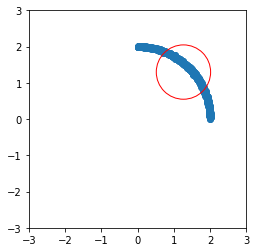

In [23]:
mx,my,r = make_initial_guess(data)
draw(mx,my,r,data)


In [25]:
r

0.749716182931196

Implementieren Sie das Gradientenabstiegtsverfahren in einer Funktion $\mathit{solve}$.

In [20]:
def solve(mx,my,r,d):
    x = np.array([mx,my,r])
    for i in range(10000):
        mx,my,r = x
        e = f(mx,my,r,d)
        df = grad(mx,my,r,d)
        df = np.array(df)
        x = x -0.0001*df
    return e,mx,my,r

Führen sie das Gradientenabstiegsverfahren aus und starten Sie mit Ihrer initialen Schätzung. Plotten Sie Ihr Ergebnis mit $\mathit{draw}$.

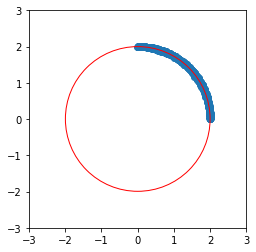

In [21]:
_,res_mx, res_my, res_r = solve(mx,my,r,data)
res_mx, res_my, res_r
draw(res_mx,res_my,res_r,data)

Optional: Visualisieren Sie die Evolution der Kreisanpassung über die Zeit (Bilderfolge oder Animation).

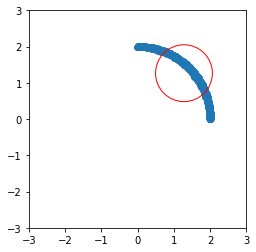

In [35]:
from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))
circle1=plt.Circle((mx,my),r,color='r',fill=False)
axes = plt.gca()
axes.set_xlim([-3,3])
axes.set_ylim([-3,3])
plt.gca().set_aspect('equal', adjustable='box')
axes.add_artist(circle1)
plt.scatter(data[0],data[1])
x = np.array([mx,my,r])

def init():
    circle1.center = x[0],x[1]
    circle1.radius = x[2]
    return (circle1,)

def animate(i):
    global x
    mx,my,r = x
    e = f(mx,my,r,data)
    df = grad(mx,my,r,data)
    df = np.array(df)
    x = x -0.0002*df
    circle1.center = x[0],x[1]
    circle1.radius = x[2]
    return (circle1,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, blit=True)


In [36]:
HTML(anim.to_html5_video())